In [1]:
from Algorithm import Gaussian_Process
from Algorithm import LA_Bayessian_Quadrature
from Algorithm import Mesh
from Algorithm import Kernels
import Target_Function as tf

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

plt.rcParams['figure.figsize'] = [12, 6]

In [2]:
opt1 = tf.Option('call', 0, 95, .25, 1.0,  15, 1)
opt2 = tf.Option('put',  1, 110, .2,  0.5,  5, 1)
portfolio = tf.OptionPortfolio(.03, 50, 150,[opt1, opt2])
D = len(portfolio.options)
func = portfolio.target_function

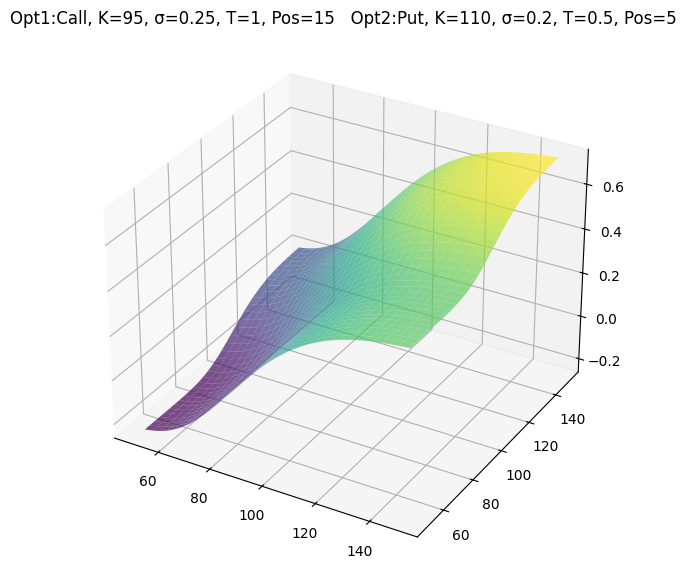

In [15]:
a = np.linspace(0., 1., 101)
b = np.linspace(0., 1., 101)
# 计算 z 值
A, B = np.meshgrid(a, b)
C = np.zeros_like(A)
for i in range(A.shape[0]):
    for j in range(A.shape[1]):
        C[i, j] = func([A[i, j], B[i, j]])

# 4. 绘图
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(portfolio.to_initial(A), portfolio.to_initial(B), C, cmap='viridis', alpha=0.7)

# 生成二维输入网格
xx = np.linspace(0., 1., 5)
yy = np.linspace(0., 1., 5)
xxx, yyy = np.meshgrid(xx, yy)
X = np.vstack([xxx.ravel(), yyy.ravel()]).T
# 生成 Y
Y = np.array([func(x) for x in X])
plt.title('Opt1:Call, K=95, σ=0.25, T=1, Pos=15   Opt2:Put, K=110, σ=0.2, T=0.5, Pos=5')
#
# for idx, i in enumerate(X):
#     ax.scatter(portfolio.to_initial(i[0]),
#                portfolio.to_initial(i[1]),
#                Y[idx], color='#6600CC', s=20)
plt.show()

In [4]:
beta = np.concatenate([
    np.array([-0.5]),
    np.random.uniform(-2, 0, size=11 * D)
])

In [5]:
xx = np.linspace(0., 1., 50)
yy = np.linspace(0., 1., 50)
xxx, yyy = np.meshgrid(xx, yy)
mesh_2D = np.vstack([xxx.ravel(), yyy.ravel()]).T
print(mesh_2D.shape)
GP = Gaussian_Process.GaussianProcess(Kernels.K_lin_mat2_10,beta,X,Y,mesh = mesh_2D)


(2500, 2)


In [6]:
GPs, int_params, ti, unce = LA_Bayessian_Quadrature.ABC_D(
    func,                # 你定义的目标函数（black-box，输入 [x1, x2]，返回 float）
    GP,                  # 你初始化好的 GaussianProcess 对象
    Mesh.get_points_D,   # 用于生成新候选点的函数（mesh.py 中的默认高维函数）
    n=30,                # 进行 30 次自适应采样（共 31 个点）
    lambd=[30, 1],       # 正则项参数，推荐默认即可
    point_mesh = mesh_2D
)
data = {
    "Step": list(range(1, len(ti) + 1)),
    "Time": ti,
    "Uncertainty": unce
}
df = pd.DataFrame(data)
df.to_csv("LABQ_original_2D.csv", index=False)

Dimensions: 2 , Steps: 31
Step 1 of 31, Time: 7.21, Result: [2.55249414e-01 2.43640769e-04], Uncertainty Rate: 6.12%
Step 2 of 31, Time: 7.15, Result: [2.58323116e-01 2.14630175e-04], Uncertainty Rate: 5.67%
Step 3 of 31, Time: 7.21, Result: [2.61318432e-01 1.86398267e-04], Uncertainty Rate: 5.22%
Step 4 of 31, Time: 7.28, Result: [2.61469475e-01 1.56843557e-04], Uncertainty Rate: 4.79%
Step 5 of 31, Time: 7.38, Result: [2.67851523e-01 1.30024317e-04], Uncertainty Rate: 4.26%
Step 6 of 31, Time: 7.65, Result: [2.80139647e-01 1.07582710e-04], Uncertainty Rate: 3.70%
Step 7 of 31, Time: 7.44, Result: [2.84087642e-01 8.02224300e-05], Uncertainty Rate: 3.15%
Step 8 of 31, Time: 7.43, Result: [2.84047939e-01 6.74268572e-05], Uncertainty Rate: 2.89%
Step 9 of 31, Time: 7.40, Result: [2.84914809e-01 5.55579275e-05], Uncertainty Rate: 2.62%
Step 10 of 31, Time: 7.51, Result: [2.85770761e-01 4.70204239e-05], Uncertainty Rate: 2.40%
Step 11 of 31, Time: 7.59, Result: [2.86533111e-01 3.67066820e-

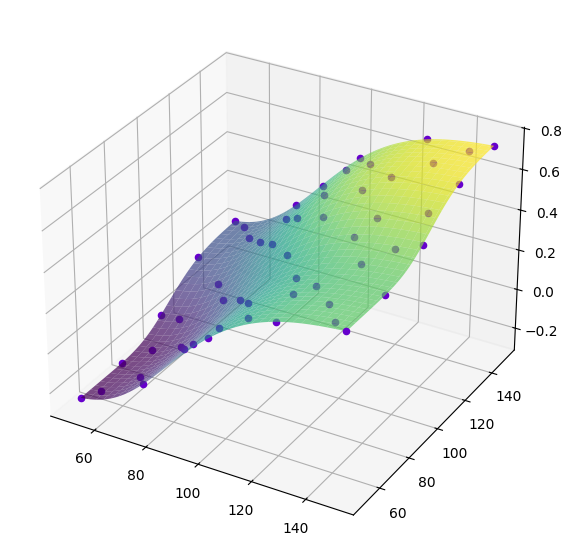

In [7]:
final_GP = GPs[-1]
pa = np.linspace(0., 1., 101)
pb = np.linspace(0., 1., 101)
PA, PB = np.meshgrid(pa, pb)
PC = np.zeros_like(PA)
for i in range(PA.shape[0]):
    for j in range(PA.shape[1]):
        PC[i, j] = func([PA[i, j], PB[i, j]])

fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(portfolio.to_initial(PA), portfolio.to_initial(PB), PC, cmap='viridis', alpha=0.7)


px = []
for i in range(len(final_GP.X.T[0])):
    px.append([final_GP.X.T[0][i], final_GP.X.T[1][i]])
py = [func(i) for i in px]


for idx, i in enumerate(px):
    ax.scatter(portfolio.to_initial(i[0]),portfolio.to_initial(i[1]), py[idx], color='#6600CC', s=20)
plt.show()

In [8]:
from scipy.stats import qmc

sampler = qmc.Sobol(d=D, scramble=True)
X_mc = sampler.random_base2(m=15)

Y_mc = np.array([func(x) for x in X_mc])

mc_mean = Y_mc.mean()
mc_var = Y_mc.var() / len(Y_mc)

print("Monte Carlo mean =", mc_mean)
print("Monte Carlo var  =", mc_var)

Monte Carlo mean = 0.28966091689840917
Monte Carlo var  = 2.315232460678259e-06


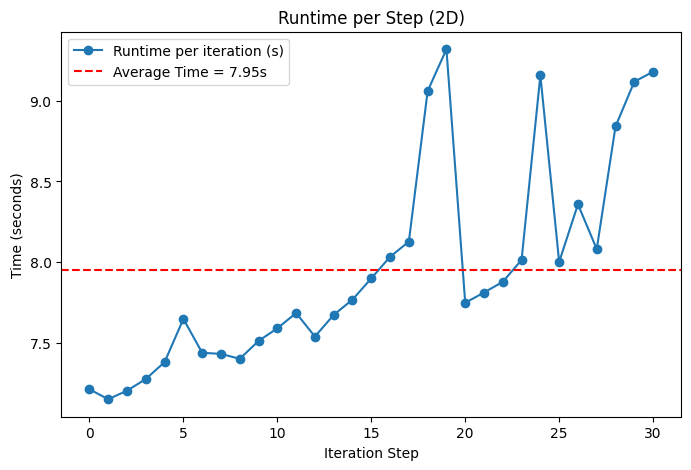

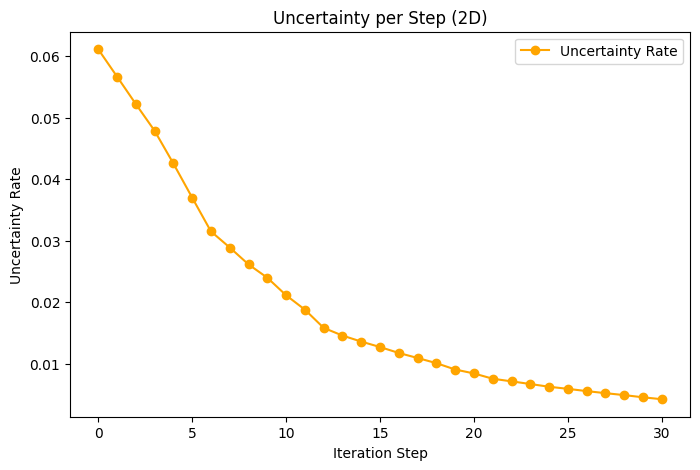

In [25]:
steps = list(range(len(ti)))
avg_time = sum(ti) / len(ti)

plt.figure(figsize=(8,5))
plt.plot(steps, ti, marker='o', label="Runtime per iteration (s)")
plt.axhline(y=avg_time, color="red", linestyle="--", label=f"Average Time = {avg_time:.2f}s")

plt.xlabel("Iteration Step")
plt.ylabel("Time (seconds)")
plt.title("Runtime per Step (2D)")
plt.legend()
plt.show()

plt.figure(figsize=(8,5))
plt.plot(steps, unce, marker='o', color="orange", label="Uncertainty Rate")
plt.xlabel("Iteration Step")
plt.ylabel("Uncertainty Rate")
plt.title("Uncertainty per Step (2D)")
plt.legend()
plt.show()